# User-Defined Processes (UDP)

openEO API allows processes to be chained together in a process graph to build a particular algorithm. Often, users have specific (sub)chains that reoccur in the same process graph or even in different process graphs or algorithms. Here user can store such (sub)chains on the back-end as a so-called user-defined process. This allows you to build your library of reusable building blocks. Ultimately, the openEO API allows you to publicly expose your user-defined process, so that other users can invoke it as a service.

This notebook provides a step-by-step guide on how to create your User-Defined Process (UDP) for Normalized Difference Water Index (NDWI) analysis. The guide covers the fundamental steps that need to be followed to create the UDP.

In [1]:
# import necessary packages

from openeo.processes import array_create
from openeo.api.process import Parameter
import openeo
import json

In [2]:
# establish a connection to the backend and authenticate

connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


The openEO Python client lets you define parameters as `Parameter` instances. In general you have to specify at least the parameter name, a description and a schema.

In [3]:
# define input parameters
time_param = Parameter(
    name="date",
    description="A date within wich you wish to load the Terrasope NDVI product.",
    schema={"type": "string"},
)
spatial_param = Parameter(
    name="aoi",
    description="Spatial extent for area of interst to calculate ndvi",
    schema={"type": "object", "subtype": "geojson"},
)

In [4]:
# specify the collection with input as parameter variables that will be used in the process

band = ["B03", "B08"]
cube = connection.load_collection(
                "SENTINEL2_L2A",
                temporal_extent=time_param,
                spatial_extent=spatial_param,
                bands=band,
)

cube = cube.max_time()

The NDWI is a vegetation index sensitive to the water content of vegetation and is complementary to the NDVI. High NDWI values show a high water content of the vegetation.
$$ \mathrm{NDWI} = \frac{\mathrm{Green} - \mathrm{NIR}}{\mathrm{Green} + \mathrm{NIR}} $$

In [5]:
green = cube.band("B03")
nir = cube.band("B08")

ndwi = (green - nir) / (green + nir)
ndwi

We can now store this as a user-defined process called NDWI on the back-end and  pass `Parameter` objects

In [7]:
# publishing the service
process_name = "NDWI"
connection.save_user_defined_process(
    user_defined_process_id=process_name,
    process_graph=ndwi,
    parameters=[time_param, spatial_param],
    public=True,
)

Now, let’s evaluate the user-defined processes we defined.

To use our custom **NDWI** process, we only have to specify a temporal and spatial extent, and let the predefined and default values do their work. We will use datacube_from_process() to construct a DataCube object which we can process further and download.

In [9]:
bbox = {"west": 5.09, "south": 51.18, "east": 5.15, "north": 51.21, "crs": 4326}
created_process = connection.datacube_from_process(
    process_id="NDWI", date=["2022-06-01", "2022-10-01"], aoi=bbox
)

In [11]:
created_process.download("output/ndwi.tiff")

### Visualize the result

In [15]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

img = rasterio.open("output/ndwi.tiff").read()


def normalizeimg(data):
    data = data.astype(float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i], in_range=(p2, p98))
    return data

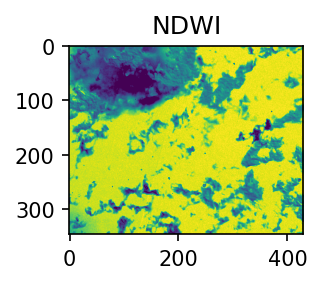

In [13]:
fig, ax = plt.subplots(figsize=(6, 2), dpi=150)
ax.imshow(normalizeimg(np.moveaxis(img, 0, -1)))

ax.set_title("NDWI")

# Adjusting the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()